<a href="https://colab.research.google.com/github/neuroprognosis/CRC-1436-IRTG-Workshop-/blob/main/predictive_modelling_tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRC 1436 IRTG Technical Workshop - Basics on Predictive Modelling






## Voxel-Based Morphometry on Oasis dataset

This example uses Voxel-Based Morphometry (VBM) to study the relationship
between aging and gray matter density.

The data come from the `OASIS <http://www.oasis-brains.org/>`_ project.
If you use it, you need to agree with the data usage agreement available
on the website.

It has been run through a standard VBM pipeline (using SPM8 and
NewSegment) to create VBM maps, which we study here.

## Predictive modeling analysis: VBM bio-markers of aging?

We run a standard SVM nilearn pipeline to predict age from the VBM
data. We use only 100 subjects from the OASIS dataset to limit the memory
usage.

Note that for an actual predictive modeling study of aging, the study
should be ran on the full set of subjects. Also, all parameters should be set
by cross-validation.


Also, parameters such as the smoothing should be applied to the data and the
number of features selected by the ANOVA step should be set by nested
cross-validation, as they impact significantly the prediction score.

____

In [12]:
!pip install nilearn

In [13]:
import nilearn
print(nilearn.version)

<module 'nilearn.version' from '/usr/local/lib/python3.7/dist-packages/nilearn/version.py'>


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data

n_subjects = 100  # more subjects requires more memory

### Part 1: Load Oasis dataset



In [15]:
# fetching oasis vbm dataset from nilearn.datasets
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:760: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [16]:
# Dataset description 
print(oasis_dataset.description)

Oasis


Notes
-----

The Open Access Series of Imaging Studies (OASIS) is a project aimed
at making MRI data sets of the brain freely available to the scientific community.

OASIS is made available by the Washington University Alzheimer’s Disease
Research Center, Dr. Randy Buckner at the Howard Hughes Medical
Institute (HHMI) at Harvard University, the Neuroinformatics Research
Group (NRG) at Washington University School of Medicine, and the Biomedical
Informatics Research Network (BIRN).


Content
-------
    :'gray_matter_maps': Nifti images with gray matter density probability
    :'white_matter_maps': Nifti images with white matter density probability maps
    :'ext_vars': Behavioral information on the participants
    :'data_usage_agreement': Text file containing the data usage agreement


References
----------
For more information about this dataset's structure:
http://www.oasis-brains.org/

Open Access Series of Imaging Studies (OASIS): Cross-sectional MRI
Data in Young, Middle 

In [17]:
# Behavioural information
oasis_dataset.ext_vars

rec.array([('OAS1_0001_MR1', 'F', 'R', 74,  2.,  3., 29., 0. , 1344, 0.743, 1.306, nan),
           ('OAS1_0002_MR1', 'F', 'R', 55,  4.,  1., 29., 0. , 1147, 0.81 , 1.531, nan),
           ('OAS1_0003_MR1', 'F', 'R', 73,  4.,  3., 27., 0.5, 1454, 0.708, 1.207, nan),
           ('OAS1_0004_MR1', 'M', 'R', 28, nan, nan, nan, nan, 1588, 0.803, 1.105, nan),
           ('OAS1_0005_MR1', 'M', 'R', 18, nan, nan, nan, nan, 1737, 0.848, 1.01 , nan),
           ('OAS1_0006_MR1', 'F', 'R', 24, nan, nan, nan, nan, 1131, 0.862, 1.551, nan),
           ('OAS1_0007_MR1', 'M', 'R', 21, nan, nan, nan, nan, 1516, 0.83 , 1.157, nan),
           ('OAS1_0009_MR1', 'F', 'R', 20, nan, nan, nan, nan, 1505, 0.843, 1.166, nan),
           ('OAS1_0010_MR1', 'M', 'R', 74,  5.,  2., 30., 0. , 1636, 0.689, 1.073, nan),
           ('OAS1_0011_MR1', 'F', 'R', 52,  3.,  2., 30., 0. , 1321, 0.827, 1.329, nan),
           ('OAS1_0012_MR1', 'M', 'R', 30, nan, nan, nan, nan, 1574, 0.842, 1.115, nan),
           ('OAS1_001

In [18]:
# selecting age 
age = oasis_dataset.ext_vars['age'].astype(float)
age = np.array(age)

# selecting gray matter maps
gm_imgs = oasis_dataset.gray_matter_maps

In [19]:
# Split data into training set and test set
from sklearn.model_selection import train_test_split
gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(gm_imgs, age, train_size=.6, random_state=0)

# print basic information on the dataset
print('First gray-matter anatomy image (3D) is located at: %s' % oasis_dataset.gray_matter_maps[0])  # 3D data
print('First white-matter anatomy image (3D) is located at: %s' % oasis_dataset.white_matter_maps[0])  # 3D data

First gray-matter anatomy image (3D) is located at: /root/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
First white-matter anatomy image (3D) is located at: /root/nilearn_data/oasis1/OAS1_0001_MR1/mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


### Part 2: Preprocess data



In [20]:
nifti_masker = NiftiMasker(standardize=False, smoothing_fwhm=2, memory='nilearn_cache')  # cache options
gm_maps_masked = nifti_masker.fit_transform(gm_imgs_train)


# The features with too low between-subject variance are removed using
# :class:`sklearn.feature_selection.VarianceThreshold`.
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=.01)
gm_maps_thresholded = variance_threshold.fit_transform(gm_maps_masked)

# Then we convert the data back to the mask image in order to use it for
# decoding process
mask = nifti_masker.inverse_transform(variance_threshold.get_support())



Prediction pipeline with SVR using
:class:`nilearn.decoding.DecoderRegressor` Object

In [29]:
from nilearn.decoding import DecoderRegressor
from sklearn.metrics import mean_absolute_error

decoder = DecoderRegressor(estimator='svr', mask=mask, scoring='neg_mean_absolute_error', n_jobs=-1)
# Fit and predict with the decoder
decoder.fit(gm_imgs_train, age_train)

# Sort test data for better visualization (trend, etc.)
perm = np.argsort(age_test)[::-1]
age_test = age_test[perm]

# Prediction
gm_imgs_test = np.array(gm_imgs_test)[perm]
age_pred = decoder.predict(gm_imgs_test)

prediction_score = mean_absolute_error(age_test, age_pred)

print("Prediction error : %f" % prediction_score)
print("")

Prediction error : 13.157600



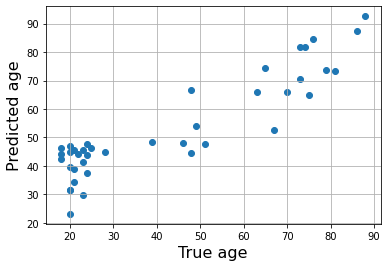

In [30]:
import matplotlib.pyplot as plt
plt.scatter(age_test, age_pred)
plt.xlabel("True age", fontsize=16)
plt.ylabel("Predicted age", fontsize=16)
plt.grid()


### Part 3: Visualization



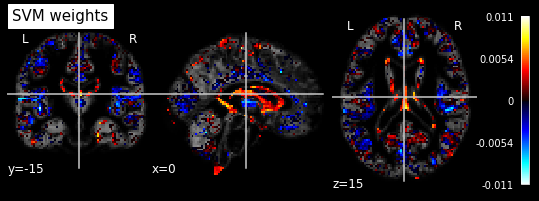

In [31]:
weight_img = decoder.coef_img_['beta']

# Create the figure
from nilearn.plotting import plot_stat_map, show
bg_filename = oasis_dataset.gray_matter_maps[0]
plot_stat_map(weight_img, bg_img=bg_filename, title='SVM weights')
plt.show()

#### Visualize the quality of predictions



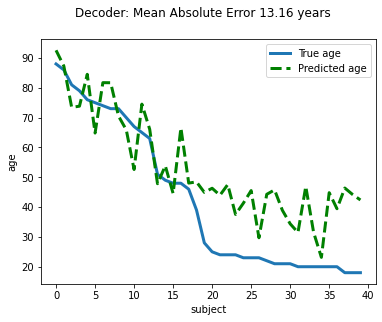

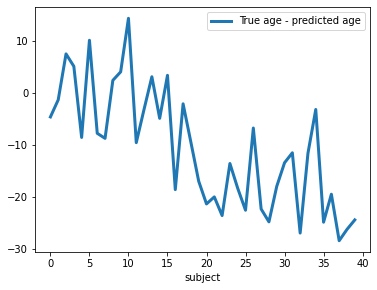

In [32]:
plt.figure(figsize=(6, 4.5))
plt.suptitle("Decoder: Mean Absolute Error %.2f years" % prediction_score)
linewidth = 3
plt.plot(age_test, label="True age", linewidth=linewidth)
plt.plot(age_pred, '--', c="g", label="Predicted age", linewidth=linewidth)
plt.ylabel("age")
plt.xlabel("subject")
plt.legend(loc="best")
plt.figure(figsize=(6, 4.5))
plt.plot(age_test - age_pred, label="True age - predicted age",
         linewidth=linewidth)
plt.xlabel("subject")
plt.legend(loc="best")

### Part 4: Measuring prediction scores using cross-validation

In [34]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)

accuracy=[]

# The "cv" object's split method can now accept data and create a
# generator which can yield the splits.
fold = 0
for train, test in cv.split(gm_imgs_train):
    fold += 1
    decoder = DecoderRegressor(estimator='svr', mask=mask, scoring='neg_mean_absolute_error', n_jobs=-1)
    train_gm = [gm_imgs[index] for index in train]
    train_target = age_train[train][::-1]
    decoder.fit(train_gm, train_target)

    #prediction
    test_gm = [gm_imgs[index] for index in test]
    test_target = age_train[test][::-1]
    prediction = decoder.predict(test_gm)
    prediction_score = mean_absolute_error(test_target, prediction)
    accuracy.append(prediction_score)
    print("CV Fold {:01d} | Prediction Accuracy: {:.3f}".format(fold,prediction_score))

CV Fold 1 | Prediction Accuracy: 28.724
CV Fold 2 | Prediction Accuracy: 23.715
CV Fold 3 | Prediction Accuracy: 25.743
CV Fold 4 | Prediction Accuracy: 26.151
CV Fold 5 | Prediction Accuracy: 18.462
